# Topics in Natural Language Processing 2019 - Assignment 2
### Dolav Nitay - 203598990

In [2]:
from collections import defaultdict
import gzip
import numpy as np

## Part 1 - Word classification

In this part we will try to build a classifier that would be able to classify which word is a complex one, and which isn't complex. This kind of classifier could be useful in the task of text simplification.

### 1.1 Evaluation metrics

First, we need functions to measure how good is our classifier. We'll mark the number of true positives by $t_{p}$, the number of false positives by $f_{p}$ the number of true negatives by $t_{n}$ and the number of false negative by $f_{n}$. We'll use the measures of **precision** which is $\frac{t_{p}}{t_{p}+f_{p}}$, that is - what is the fraction of the true positives from all the data labeled as positive, **recall** which is $\frac{t_{p}}{t_{p}+f_{n}}$, that is, what is the fraction of the true positives from all the data that should've been labeled as true. And **f score** which is $\frac{2\cdot precision\cdot recall}{precision+recall}$ and combines the measures of precision recall.

In [3]:
""" Calculates the number of true positives, false positives, true negatives, and false negatives, given
    the predicted labels and the true labels."""
def get_measures(y_pred, y_true):
    tup_list = list(zip(y_pred, y_true))
    t_p = len(list([tup for tup in tup_list if tup[0]==tup[1]==1]))
    f_p = len(list([tup for tup in tup_list if tup[0]==1 and tup[1]==0]))
    t_n = len(list([tup for tup in tup_list if tup[0]==tup[1]==0]))
    f_n = len(list([tup for tup in tup_list if tup[0]==0 and tup[1]==1]))
    return {'true_positive':t_p, 'false_positive':f_p, 'true_negative':t_n, 'false_negative':f_n}


Let's test this method on some simple data and see what we get.

In [4]:
get_measures([1,1,1,1],[0,1,0,1])

{'true_positive': 2,
 'false_positive': 2,
 'true_negative': 0,
 'false_negative': 0}

In [5]:
get_measures([1,0,1,0],[1,1,1,1])

{'true_positive': 2,
 'false_positive': 0,
 'true_negative': 0,
 'false_negative': 2}

That looks good. Now let's use these measures and formulas mentioned before to calculate our precision, recall, and f-score. 

In [6]:

## Calculates the precision of the predicted labels
def get_precision(y_pred, y_true):
    measures = get_measures(y_pred, y_true)
    precision = (measures['true_positive']/(measures['true_positive']+measures['false_positive']))
    return precision
    
## Calculates the recall of the predicted labels
def get_recall(y_pred, y_true):
    measures = get_measures(y_pred, y_true)
    recall = (measures['true_positive']/(measures['true_positive']+measures['false_negative']))
    return recall

## Calculates the f-score of the predicted labels
def get_fscore(y_pred, y_true):
    recall, precision = get_recall(y_pred, y_true), get_precision(y_pred, y_true)
    fscore = (2*precision*recall)/(precision+recall)
    return fscore

Let's test this methods on some simple data and see how the measures of precision recall and f-score behave on it.

In [7]:
get_precision([1,0,1,0],[1,1,1,1])

1.0

Since all our data was labeled as positive, our precision is 1.0 as naturally, false positive isn't possible on such data, and all the data we labeled as true must be true positive.<br>
Let's test the recall.

In [8]:
get_recall([1,0,1,0],[1,1,1,1])

0.5

We labeled only half of the real positive labels as true, so our recall is $\frac{1}{2}$. Let's see what is our f-score.

In [9]:
get_fscore([1,0,1,0],[1,1,1,1])

0.6666666666666666

According to our formula we get that $fscore=\frac{2\cdot precision\cdot recall}{precision+recall}=\frac{2\cdot 1\cdot \frac{1}{2}}{\frac{3}{2}}=\frac{1}{\frac{3}{2}}=\frac{2}{3}$.
We can see that the f-score merges both measures into a single one, and that using only one them can be deceptive.

### 1.2 Baselines
We'll implement a few baselines, so we could compare are more sophisticated classifiers to them later.
First, we need a function that would load the training and validation words and labels. 

In [10]:
def load_file(data_file):
    words = []
    labels = []   
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    return words, labels

Our first baseline classifier will label all words as complex. Let's see how such classifier performs on the training and development data.

In [11]:
def all_complex(data_file):
    words, labels = load_file(data_file)
    tags = [1 for word in words]
    precision, recall, fscore = get_precision(tags, labels), get_recall(tags, labels), get_fscore(tags, labels)
    performance = [precision, recall, fscore]
    return performance

We need our training and development data, to test this baseline classifier on.

In [12]:
TRAINING_PATH = "../data/complex_words_training.txt"
DEV_PATH = "../data/complex_words_development.txt"

In [15]:
def print_performance(title,performance):
    delimeter = '-'*(len(title))
    print("{t}\n{d}\nPrecision:{l[0]}\nRecall:{l[1]}\nf-score:{l[2]}\n".format(t=title,d=delimeter,l=performance))

print_performance("All complex",all_complex(TRAINING_PATH))

All complex
-----------
Precision:0.43275
Recall:1.0
f-score:0.604083057058105



The recall is 1 since we labeled all the words as complex, so we couldn't have missed any complex word. The precision is less then 0.5, which means that most of the words aren't complex, and we labeled them as complex anyway.<br>
Let's create a more sophisticated baseline. We'll use the heuristic that a complex word is likely a long one, while a less complex word is probably a short one. Our baseline classifier will label all words longer than a give threshold $t$ as complex, and all words shorter as not complex. We'll have to find the optimal value of $t$ - the one which gives us the highest f-score, and then see what results we get with that value on the training and development data. We'll use $t\in\{2,3,4,...,15\}$ and see which value is optimal from that set.

In [16]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
threshold_range = range(2,15)

First, we'll create our baseline classifier, which given a threshold $t$, labels all words longer than or equal to $t$ as complex, and all words shorter than $t$ as non-complex.

In [17]:
def get_performance_threshold(words, labels, threshold):
    tags = [1 if len(word)>=threshold else 0 for word in words]
    precision, recall, fscore = get_precision(tags, labels), get_recall(tags, labels), get_fscore(tags, labels)
    performance = [precision, recall, fscore]
    return performance


For visualization, we'll also plot graphs of the f score as a function of the threshold, and the dependency between precision and recall. We'll create a function for drawing these graphs.

In [18]:
import seaborn as sns
import pandas as pd

def plot_graphs(performances, t_range):
    sns.set(style="darkgrid", palette='Blues_r')
    f_scores = [performance[0][2] for performance in performances]
    sns.relplot(x="threshold", y="fscore", kind='line',
       data=pd.DataFrame([{'threshold':t,'fscore':sc} for t,sc in zip(t_range, f_scores)]));
    sns.relplot(x="Recall", y="Precision",
           data=pd.DataFrame([{'Recall':performance[0][1],'Precision':performance[0][0]} for performance in performances]));


Let's plot the graphs now for the training data.

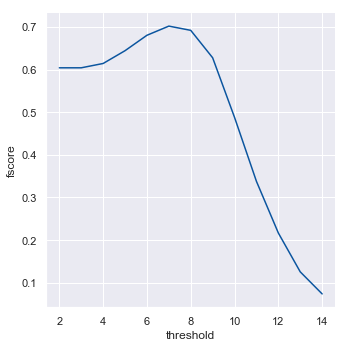

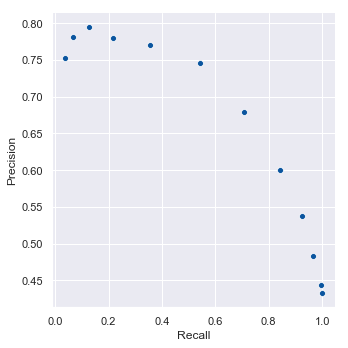

In [19]:
words,labels = load_file(TRAINING_PATH)
performances = [(get_performance_threshold(words, labels, t),t) for t in threshold_range]
plot_graphs(performances, threshold_range)

And now for the development data.

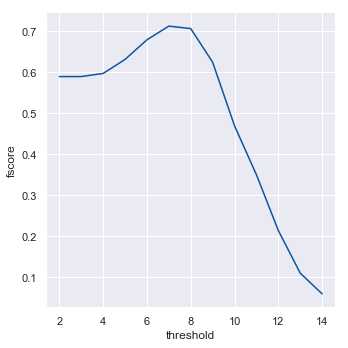

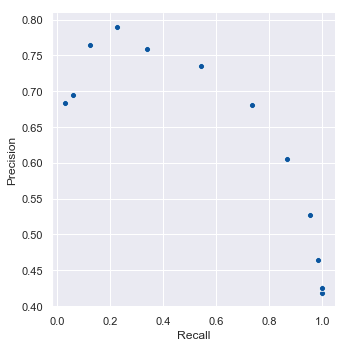

In [20]:
words,labels = load_file(DEV_PATH)
performances = [(get_performance_threshold(words, labels, t),t) for t in threshold_range]
plot_graphs(performances, threshold_range)

We can see that both the training and the development data receives their maximum f-score for $t=8$. Also we can see that the percision and recall are inversely related.
Now we'll create a method which given the words and the labels, will return the threshold that gives the optimal f-score.

In [21]:
def get_opt_fscore(words, labels):
    performances = [(get_performance_threshold(words, labels, t),t) for t in threshold_range]
    opt_val = max(performances, key=lambda a:a[0][2])[1]
    return opt_val
    
def word_length_threshold(training_file, development_file):
    words, labels = load_file(training_file)
    opt_fscore = get_opt_fscore(words, labels)
    tprecision, trecall, tfscore = tuple(get_performance_threshold(words, labels, opt_fscore))
    words, labels = load_file(development_file)
    dprecision, drecall, dfscore = tuple(get_performance_threshold(words, labels, opt_fscore))
    training_performance = [tprecision, trecall, tfscore]
    development_performance = [dprecision, drecall, dfscore]
    return training_performance, development_performance

Let's use this method to calculate the optimal threshold on the training data, and then calculate all our measures on the development data.

In [22]:
t,d = word_length_threshold(TRAINING_PATH, DEV_PATH)
print_performance("Training word length threshold",t)
print_performance("Development word length threshold",d)

Training word length threshold
------------------------------
Precision:0.6007401315789473
Recall:0.8440207972270364
f-score:0.7018976699495555

Development word length threshold
---------------------------------
Precision:0.6053511705685619
Recall:0.8660287081339713
f-score:0.7125984251968505



We can see that we achieved better results on our development data than on our training data. This isn't suprising since we've noticed that both received the optimal f-score for the same value of $t$.

Now we'll create a different base line, this time we'll use the frequency in which the word appeared in a file as the feature by which we decide whether a word is complex or not. If a word is frequent, we'll label it as non complex, if it's rare, we'll label it as complex. Like in the word length example, we'll test various thresholds on our training data to see which yields the best f-score.<br>
First, we need a function to load the data of the frequencies, and load it into a python dictionary.

In [23]:
NGRAM_PATH = "../data/ngram_counts.txt.gz"
def load_ngram_counts(ngram_counts_file): 
    counts = defaultdict(int) 
    with gzip.open(ngram_counts_file, 'rt', errors='ignore') as f: 
        for line in f:
            token, count = line.strip().split('\t') 
            if token[0].islower(): 
                counts[token] = int(count)
    return counts

counts = load_ngram_counts(NGRAM_PATH)

Let's see what is the average frequency of a word, to determine in what range our thresholds should be.

In [24]:
np.mean(np.array(list(counts.values())))

155953.65044112835

The mean is 155953, we'll need high values of threshold. We'll test values between 50,000 and 1,000,000 with 50,000 difference between each value.

In [25]:
freq_range = range(50000,1000000, 50000)

Now let's create the function that would label our words, and would measure our performance on a given set of labels, given a threshold.

In [26]:
def get_performance_word_threshold(words, labels, counts, threshold):
    tags = [1 if counts[word]<=threshold else 0 for word in words]
    precision, recall, fscore = get_precision(tags, labels), get_recall(tags, labels), get_fscore(tags, labels)
    performance = [precision, recall, fscore]
    return performance

Let's see how our f-score behaves on the training data for various values of $t$.

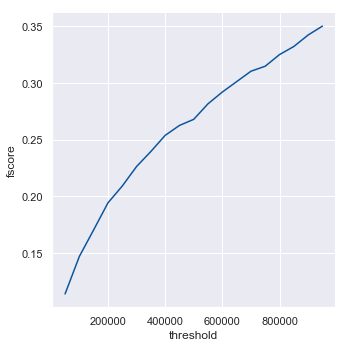

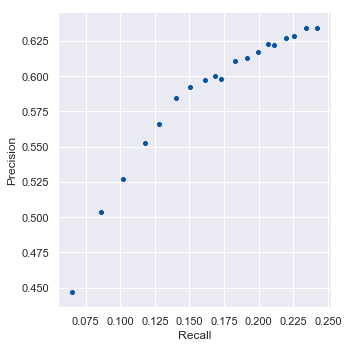

In [27]:
words,labels = load_file(TRAINING_PATH)
performances = [(get_performance_word_threshold(words, labels, counts, t),t) for t in freq_range]
plot_graphs(performances, freq_range)

We can see here two interesting things. First that the f-score is still rising, and that both the precision and the recall are increasing. Most likely we've picked too low values of $t$. Let's try again, this time with $t\in\{50000,150000,250000,...,10000000\}$

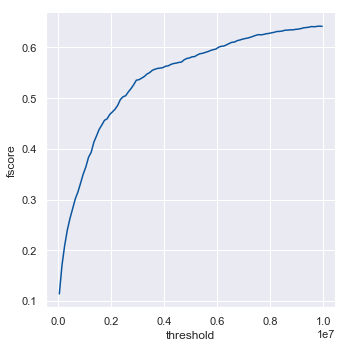

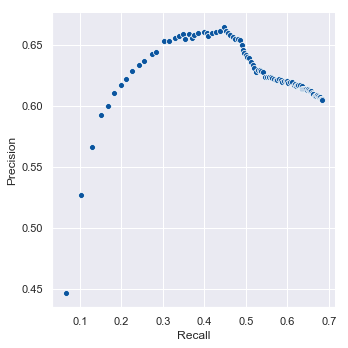

In [28]:
freq_range = range(50000,10000000, 100000)
performances = [(get_performance_word_threshold(words, labels, counts, t),t) for t in freq_range]
plot_graphs(performances, freq_range)

The value of the fscore still increases, but less drastically, and we can see the inverse dependency between the precision and the recall. Let's try now $t\in\{50000,550000,1050000,...,100000000\}$

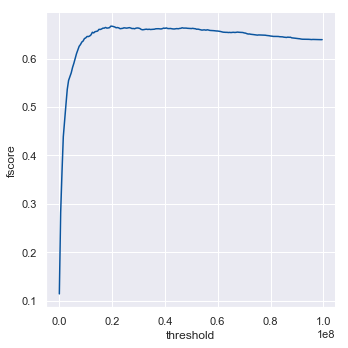

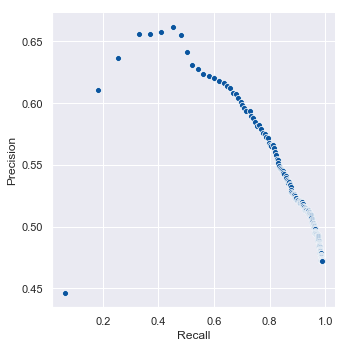

In [29]:
freq_range = range(50000,100000000, 500000)
performances = [(get_performance_word_threshold(words, labels, counts, t),t) for t in freq_range]
plot_graphs(performances, freq_range)

And for the development data:

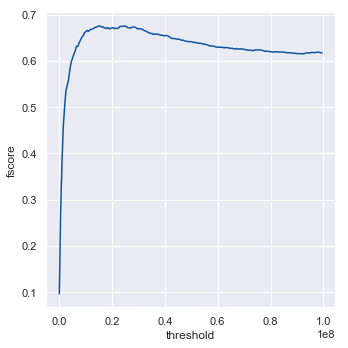

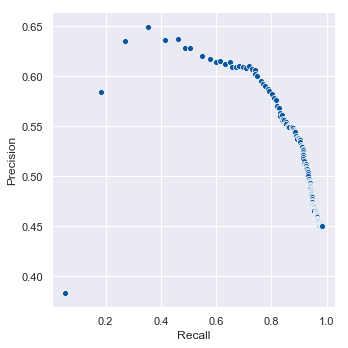

In [30]:
words,labels = load_file(DEV_PATH)
performances = [(get_performance_word_threshold(words, labels, counts, t),t) for t in freq_range]
plot_graphs(performances, freq_range)

That seems better. We can see that the fscore receives a maximal value, and the inverse dependency between the precision and the recall. Now let's create a function that would measure the optimal value of $t$, and we'll use it to test our baseline on the test and development data.

In [31]:
def get_opt_freq_fscore(words, labels, counts):
    performances = [(get_performance_word_threshold(words, labels, counts, t),t) for t in freq_range]
    opt_val = max(performances, key=lambda a:a[0][2])[1]
    return opt_val

def word_frequency_threshold(training_file, development_file, counts):
    words, labels = load_file(training_file)
    opt_val = get_opt_freq_fscore(words, labels, counts)
    tprecision, trecall, tfscore = tuple(get_performance_word_threshold(words, labels, counts, opt_val))
    words, labels = load_file(development_file)
    dprecision, drecall, dfscore = tuple(get_performance_word_threshold(words, labels, counts, opt_val))
    training_performance = [tprecision, trecall, tfscore]
    development_performance = [dprecision, drecall, dfscore]
    return training_performance, development_performance

In [32]:
t,d = word_frequency_threshold(TRAINING_PATH, DEV_PATH, counts)
print_performance("Training word frequency threshold",t)
print_performance("Development word frequency threshold",d)

Training word frequency threshold
---------------------------------
Precision:0.5660757453666398
Recall:0.8116695551704217
f-score:0.666983147400902

Development word frequency threshold
------------------------------------
Precision:0.5569620253164557
Recall:0.8421052631578947
f-score:0.6704761904761904



We can see that the f-score we got on the training and development data is lower than the one we got using the word length baseline. Perhaps more sophisticated classifiers, with a combination of both features, will be able to perform better.

### 1.3 Classifiers
We will use sklearn's naive bayes classifier on the task of deciding whether a word is complex or not.
Our features would be the the word length and it's frequency. We'll normalize our features using the mean and the standard deviation. Let's write a function for normalizing an numpy array of features.

In [33]:
from sklearn.naive_bayes import GaussianNB
import sklearn.preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import TransformerMixin

We'll need to extract our features from each word before classifying them. We'll use sklearn's pipeline, to create a pipeline which will extract the features, normalize them, and then classify our data.

First, we need to implement transformers which will extract features from the given data. Let's create a LengthTransformer, which extracts the length of each word.

In [34]:
class LengthTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        lengths = [len(x) for x in X]
        return np.array([len(x) for x in X], dtype='float64').reshape(-1,1)

    def fit(self, X, y=None, **fit_params):
        return self

And a count transformer, which will extract the frequency of each word.

In [35]:
class CountTransformer(TransformerMixin):

    def __init__(self, counts):
        self.counts = counts
    
    def transform(self, X, **transform_params):
        return np.array([self.counts[x] for x in X], dtype='float64').reshape(-1,1)

    def fit(self, X, y=None, **fit_params):
        return self

After extracting our features, we'll have to normalize them. We'll use sklearn's normalizer to normalize our features. This normalizer will also learn the mean and std of the training data, so they could be applied later to the test data. Now, let's create the pipeline, which will extract the features, normalize them, and then classify them.

In [36]:
def get_pipeline(counts):
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('length', LengthTransformer()),
            ('count', CountTransformer(counts))
        ])),
        ('normalizer', sklearn.preprocessing.StandardScaler()),
        ('classifier', GaussianNB())
    ])
    return pipeline

Now we'll create the method which will test our classifier.

In [37]:
def naive_bayes(training_file, development_file, counts):
    pipeline = get_pipeline(counts)
    words, labels = load_file(training_file)
    pipeline.fit(words, labels)
    tags = pipeline.predict(words)
    tprecision, trecall, tfscore = get_precision(tags, labels), get_recall(tags, labels), get_fscore(tags, labels)
    words, labels = load_file(development_file)
    tags = pipeline.predict(words)
    dprecision, drecall, dfscore = get_precision(tags, labels), get_recall(tags, labels), get_fscore(tags, labels)
    training_performance = [tprecision, trecall, tfscore]
    development_performance = [dprecision, drecall, dfscore]
    return training_performance, development_performance

In [38]:
t,d = naive_bayes(TRAINING_PATH, DEV_PATH, counts)
print_performance("Training word frequency threshold",t)
print_performance("Development word frequency threshold",d)

Training word frequency threshold
---------------------------------
Precision:0.4950379451255108
Recall:0.9797804737146159
f-score:0.6577467519875897

Development word frequency threshold
------------------------------------
Precision:0.46929316338354576
Recall:0.9688995215311005
f-score:0.6323185011709602



The scores we got here are less than the baselines.

### 1.4 Ambiguty
In order to find out if the complexity of words is ambigous, we have to use the context information given to us in the dataset. Let's load this data.

In [39]:
def load_file_context(data_file):
    words = []
    labels = []
    contexts = []
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
                contexts.append(line_split[3])
            i += 1
    return words, labels, contexts

Next, we need to find out if there is some word which was labeled once as complex, and once as not complex. We can use the counter data structure to find all the words that appear more than once in our data.

In [40]:
from collections import Counter
words, labels, contexts = load_file_context(TRAINING_PATH)
c = Counter(words)

Let's create a list of all the words that appear more than once in our dataset, the indices in which they occur, and each of their labels.

In [41]:
occ = [(w,[(labels[ind],ind) for ind,word in enumerate(words) if word==w])  for w,n in c.items() if n>1]

Now, let's filter the words that were labeled the same in all their occourrences, and leave only the words that receive different labels.

In [42]:
occ = list(filter(lambda a:not all(a[1][0][0]==rest for rest in [tup[0] for tup in a[1]]),occ))

Let's print all those words, together with their context, and see if you can find an evidence to a word whose complexity is ambigous.

In [43]:
for word, labels in occ:
    print('-'*80)
    print(word)
    for label, ind in labels:
        print('complex' if label==1 else 'not complex')
        print(contexts[ind])
        print('-'*20)

--------------------------------------------------------------------------------
campaign
not complex
`` Given the way the meeting transpired , '' Ray Halbritter , an Oneida representative and leader of the `` Change the Mascot Campaign , '' said Wednesday , `` it became somewhat evident they were defending the continued use of the name .
--------------------
complex
The campaign around the Maine Bear Hunting Ban Initiative , which will appear on the ballot as Question 1 , has shed light on Maine 's unique status in the wildlife world .
--------------------
--------------------------------------------------------------------------------
element
not complex
Element 118 , for example , is the heaviest element to date , with 118 protons alongside 176 neutrons .
--------------------
complex
Arturo Sanchez is in his element .
--------------------
--------------------------------------------------------------------------------
inspired
complex
Miguel Castañeda started Tech Connect in 2009 , 

In most words there isn't a direct connection between the context and the labeling of the words, in one of them (indy) the same word received different labeld in the same context, while in most others, while the context is different, the meaning of the word is the same, and I don't see a reason for the different labeling.
The only example I can see for ambiguty, is the "element" word. The word was labeled as not complex in the first sentence, when it referred to chemical element. While it was labeled as complex in the second sentence, where it appeared in the context of "not in his element".

## Part 2 - Document classification

### 2.1 Reuters dataset
Let's execute the notebook out of core classification.

### 2.1.1
In order to get some statistics about the data, we first need to import it. We'll use the ReutersParser from the notebook for importing and parsing the data.

In [320]:
import os
from glob import glob
from sklearn.datasets import get_data_home
from sklearn.externals.six.moves import html_parser
from nltk import word_tokenize
import re

class ReutersParser(html_parser.HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        html_parser.HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""

Now let's load the dataset, also, we'll count the number of words and characters in the dataset.

In [331]:
data_path = os.path.join(get_data_home(), "reuters")
parser = ReutersParser()
total_len = 0
total_words = 0
l = []
for filename in glob(os.path.join(data_path, "*.sgm")):
    for doc in parser.parse(open(filename, 'rb')):
        l.append(doc)
        total_len = total_len + len(doc['body'])
        total_words = total_words + len(word_tokenize(doc['body']))

We want to count how many categories there are in the dataset, and how many documents there are per category. We'll use a pandas dataframe for that. First, let's create a dataframe from the list we got earlier.

In [330]:
d = pd.DataFrame(l)

Let's see how many documents there are in the dataset:

In [335]:
len(d)

21578

Each document can belong to multiple categories. We want to be able to analyze each topic seperately. Let's create a new dataframe with the topics column seperated, so that each document will appear once with each of his categories.

In [332]:
p = d.topics.apply(pd.Series).merge(d, left_index=True, right_index=True).drop('topics', axis=1)\
.melt(id_vars=['body','title'],value_name='topic').drop('variable', axis=1).dropna()

Now let's count how many documents there are per category, to get statistics about the distribution.

In [337]:
topics = p['topic'].value_counts()

Let's see how many documents belong to each category:

In [339]:
topics

usa             12542
earn             3987
acq              2448
uk               1489
japan            1138
canada           1104
money-fx          801
crude             634
grain             628
west-germany      567
trade             552
interest          513
france            469
ec                349
brazil            332
wheat             306
ship              305
australia         270
corn              254
china             223
dlr               217
ussr              216
switzerland       214
belgium           214
netherlands       196
oilseed           192
money-supply      190
sugar             184
iran              179
italy             170
                ...  
rubio               1
bhutan              1
corn-oil            1
ose                 1
red-bean            1
bahamas             1
russell             1
vanuatu             1
siregar             1
kiechle             1
euratom             1
citruspulp          1
iwcc                1
set                 1
johnston  

Let's get some more statistics like count, mean , standard deviation, min and max, using pandas library's describe() method.

In [340]:
topics.describe()

count      445.000000
mean        89.871910
std        644.656909
min          1.000000
25%          3.000000
50%          8.000000
75%         37.000000
max      12542.000000
Name: topic, dtype: float64

### 2.1.2
We counted earlier the number of characters and words in the dataset. Let's print it:

In [336]:
print('number of characters:{0}\nnumber of words:{1}'.format(total_len,total_words))

number of characters:15504389
number of words:2854622


### 2.1.3 
The classifiers that support the partial-fit method, discussed in the notebook, are those that can perform online machine learning, that is - they can learn the function $f$ without seeing the entire dataset, but only seeing parts of it sequentially. These classifiers are useful when dealing with large datasets that cannot fit into the main memory. An example for such an algorithm is the Stochastic Gradient Descent (SGD) used in the notebook.

### 2.1.4
The hashing vectorizer is using an hash function to find the index in the vector each word would map to. This is useful, since in partial-fit, we don't see the entire dataset before the learning, and hence cannot map each word in it to an integer (We don't fit the vectorizer). Also, we don't need to keep the entire vocabulary as a dictionary in memory, which could be useful for a large vocabulary.

### 2.2 - Spam dataset
We'll execute the given notebook on spam data classification. For convinience, we'll copy some of it's methods to this notebook. First, let's load the data.

In [44]:
%matplotlib inline
import os
import sys
import numpy
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score

def progress(i, end_val, bar_length=50):
    '''
    Print a progress bar of the form: Percent: [#####      ]
    i is the current progress value expected in a range [0..end_val]
    bar_length is the width of the progress bar on the screen.
    '''
    percent = float(i) / end_val
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
    sys.stdout.flush()

NEWLINE = '\n'

HAM = 'ham'
SPAM = 'spam'

SOURCES = [
    ('data/spam',        SPAM),
    ('data/easy_ham',    HAM),
    ('data/hard_ham',    HAM),
    ('data/beck-s',      HAM),
    ('data/farmer-d',    HAM),
    ('data/kaminski-v',  HAM),
    ('data/kitchen-l',   HAM),
    ('data/lokay-m',     HAM),
    ('data/williams-w3', HAM),
    ('data/BG',          SPAM),
    ('data/GP',          SPAM),
    ('data/SH',          SPAM)
]

SKIP_FILES = {'cmds'}


def read_files(path):
    '''
    Generator of pairs (filename, filecontent)
    for all files below path whose name is not in SKIP_FILES.
    The content of the file is of the form:
        header....
        <emptyline>
        body...
    This skips the headers and returns body only.
    '''
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):
                    past_header, lines = False, []
                    f = open(file_path, encoding="latin-1")
                    for line in f:
                        if past_header:
                            lines.append(line)
                        elif line == NEWLINE:
                            past_header = True
                    f.close()
                    content = NEWLINE.join(lines)
                    yield file_path, content


def build_data_frame(l, path, classification):
    rows = []
    index = []
    for i, (file_name, text) in enumerate(read_files(path)):
        if ((i+l) % 100 == 0):
            progress(i+l, 58910, 50)
        rows.append({'text': text, 'class': classification})
        index.append(file_name)
   
    data_frame = DataFrame(rows, index=index)
    return data_frame, len(rows)

def load_data():
    data = DataFrame({'text': [], 'class': []})
    l = 0
    for path, classification in SOURCES:
        data_frame, nrows = build_data_frame(l, path, classification)
        data = data.append(data_frame, sort=False)
        l += nrows
    data = data.reindex(numpy.random.permutation(data.index))
    return data

data=load_data()

Percent: [##################################################] 100%

We'll observe how much emails and sms messages we have in our dataset:

In [284]:
len(data)

58910

How many of those messages are spam:

In [285]:
len(data[data['class']=='spam'])

35371

And how many of those messages are ham:

In [286]:
len(data[data['class']=='ham'])

23539

Now, let's create the vectorizer, and the classifier.

In [294]:
def build_pipeline():
    pipeline = Pipeline([
        ('count_vectorizer',   CountVectorizer(ngram_range=(1, 2))),
        ('classifier',         MultinomialNB())
    ])
    return pipeline

def train(data = None, n_folds = 6):
    if data is None:
        print("Loading data...")
        data = load_data()
        print("Data loaded")
    k_fold = KFold(n_splits = n_folds)
    pipeline = build_pipeline()
    scores = []
    confusion = numpy.array([[0, 0], [0, 0]])
    print("Training with %d folds" % n_folds)
    for i, (train_indices, test_indices) in enumerate(k_fold.split(data)):
        train_text = data.iloc[train_indices]['text'].values
        train_y = data.iloc[train_indices]['class'].values.astype(str)

        test_text = data.iloc[test_indices]['text'].values
        test_y = data.iloc[test_indices]['class'].values.astype(str)

        print("Training for fold %d" % i)
        pipeline.fit(train_text, train_y)
        print("Testing for fold %d" % i)
        predictions = pipeline.predict(test_text)

        confusion += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label=SPAM)
        scores.append(score)
        print("Score for %d: %2.2f" % (i, score))
        print("Confusion matrix for %d: " % i)
        print(confusion)

    print('Total emails classified:', len(data))
    print('Score:', sum(scores)/len(scores))
    print('Confusion matrix:')
    print(confusion)
    return pipeline

from sklearn.linear_model import LogisticRegression

def build_pipeline2():
    pipeline = Pipeline([
        ('count_vectorizer',   CountVectorizer(ngram_range=(1,2))),
        ('classifier',         LogisticRegression(solver='lbfgs'))
    ])
    return pipeline

def train2(data = None, n_folds = 4):
    if data is None:
        print("Loading data...")
        data = load_data()
        print("Data loaded")
    k_fold = KFold(n_splits = n_folds)
    pipeline = build_pipeline2()
    scores = []
    confusion = numpy.array([[0, 0], [0, 0]])
    print("Training with %d folds" % n_folds)
    for i, (train_indices, test_indices) in enumerate(k_fold.split(data)):
        train_text = data.iloc[train_indices]['text'].values
        train_y = data.iloc[train_indices]['class'].values.astype(str)
        test_text = data.iloc[test_indices]['text'].values
        test_y = data.iloc[test_indices]['class'].values.astype(str)
        
        print("Training for fold %d" % i)
        pipeline.fit(train_text, train_y)
        print("Testing for fold %d" % i)
        predictions = pipeline.predict(test_text)
        
        confusion += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label=SPAM)
        scores.append(score)
        
        print("Score for %d: %2.2f" % (i, score))
        print("Confusion matrix for %d: " % i)
        print(confusion)

    print('Total emails classified:', len(data))
    print('Score:', sum(scores)/len(scores))
    print('Confusion matrix:')
    print(confusion)
    return pipeline

pipeline = train2(data)
pipeline_nb = train(data)

Training with 4 folds
Training for fold 0
Testing for fold 0
Score for 0: 1.00
Confusion matrix for 0: 
[[5803   27]
 [  53 8845]]
Training for fold 1
Testing for fold 1
Score for 1: 0.99
Confusion matrix for 1: 
[[11745    56]
 [  114 17541]]
Training for fold 2
Testing for fold 2
Score for 2: 1.00
Confusion matrix for 2: 
[[17631    92]
 [  164 26296]]
Training for fold 3
Testing for fold 3
Score for 3: 0.99
Confusion matrix for 3: 
[[23417   122]
 [  228 35143]]
Total emails classified: 58910
Score: 0.9950444855355758
Confusion matrix:
[[23417   122]
 [  228 35143]]
Training with 6 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.98
Confusion matrix for 0: 
[[3876   12]
 [ 258 5673]]
Training for fold 1
Testing for fold 1
Score for 1: 0.98
Confusion matrix for 1: 
[[ 7818    24]
 [  487 11309]]
Training for fold 2
Testing for fold 2
Score for 2: 0.98
Confusion matrix for 2: 
[[11753    48]
 [  705 16950]]
Training for fold 3
Testing for fold 3
Score for 3: 0.98
Confusion 

### 2.2.1
In order to get some statistics about our unigrams and bigrams, let's take the vectorizer from the pipeline.

In [48]:
vectorizer = pipeline.named_steps['count_vectorizer']

In order to see how many unigrams and bigrams we have in our dataset, let's see the length of our features names vector.

In [42]:
len(vectorizer.get_feature_names())

3183614

### 2.2.2
We want to count the most common unigrams and bigrams, let's create a sparse matrix describing our dataset.

In [50]:
sparse_matrix = vectorizer.transform(data.text)

We'll sum each column of the matrix to get the total appearences of each unigram and bigram. And insert the data into a pandas dataframe.

In [57]:
l = sum(sparse_matrix).data
p = pd.DataFrame(l, index=vectorizer.get_feature_names(), columns=['frequency'])

Let's sort the dataframe to see the top appearing unigrams and bigrams.

In [61]:
sorted_p = p.sort_values(by=['frequency'], ascending=False)
sorted_p[:50]

,frequency
font,588020
3d,573645
the,523545
br,506598
td,412043
to,384631
and,304840
nbsp,288463
of,276364
http,240249


It seems that the most frequent unigrams and bigrams appearing in our data are simply html tags, and parts of internet addresses.

### 2.2.3
Let's now divide our data by the the tags, and see which are the frequent unigrams and bigrams among the spam messages, and which are the frequent unigrams and bigrams among the ham messages.

In [56]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
sparse_matrix = vectorizer.fit_transform(data.text[data['class']== 'spam'])

In [57]:
l = sum(sparse_matrix).data

In [61]:
p = pd.DataFrame(l, index=vectorizer.get_feature_names(), columns=['frequency'])
sorted_p = p.sort_values(by=['frequency'], ascending=False)
sorted_p[:50]

,frequency
http h2c4nv,560956
http gwardys,543929
http haberdashery,485533
http gzoujtdcfnibi,365696
http exultation,278903
http insofar,251806
http h0,213214
http gzonesite,202543
http inodamer,198919
http maglaras,193515


The most common unigrams and bigrams among the spam messages are parts of internet address, probably links to websites which send a lot of smap messages. Let's see what are the most common unigrams and bigram among the ham messages.

In [45]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
sparse_matrix = vectorizer.fit_transform(data.text[data['class']== 'ham'])

In [46]:
l = sum(sparse_matrix).data

In [47]:
p = pd.DataFrame(l, index=vectorizer.get_feature_names(), columns=['frequency'])
sorted_p = p.sort_values(by=['frequency'], ascending=False)
sorted_p[:50]

,frequency
invented them,271739
invariably there,185712
invalidation failed,123494
invaluable to,116399
invented all,90256
inventive of,71121
invalid_msgid does,70561
known meters,70004
invasion,60087
inv hd,59190


Among the ham messages, the most common unigrams and bigrams are actual words that we would expect seeing in messages.

### 2.2.4
We'll now use sklearn's SelectFromModel to find the most useful features our classifier used to distinguish between spam and ham messages.

In [67]:
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest

Let's fit our vectorizer to the data, and transform our data to a matrix of features vectors.

In [51]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
x_train = vectorizer.fit_transform(data['text'])

Now let's fit our SelectFromModel to our data.

In [102]:
y_train = [0 if c=='ham' else 1 for i,c in enumerate(data['class'])]
clf = MultinomialNB()
clf.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

We need to sort our coefficents to find which are the most useful.

In [104]:
s = np.argsort(clf.coef_[0])

Each feature in our model is a unigram or a bigram. We can get the those unigrams and bigrams from our vectorizer.

In [92]:
names = vectorizer.get_feature_names()

The last 20 features in our sorted array are the features most useful to determine that a message is a spam message. Let's print them.

In [105]:
for j in s[-20:]:
    print(names[j])

span
style
border
face
br br
of
width
nbsp nbsp
and
http
20
to
tr
size
the
nbsp
td
br
3d
font


And the top 20 features in our sorted array are the features most useful to determine that a message is ham message.

In [98]:
for j in s[:20]:
    print(names[j])

illumine sheather
derail deal
printformat page
printing 2x
derail barbour
derail amble
derail afar
printing as
deracialize3eras7frettingcombatterdromotropic body
deracialize3eras7frettingcombatterdromotropic
deracialize eras3
printformat
deracialize
printing br
der übliche
der überschuldung
der übereinstimmung
printing cd
der zustellung
der zussammen


### 2.2.5 
The length attribute should be normalized, since the features of each document in this task consists of the BoW and the number of words, we want them to be on the same scale, so that the number of words won't dominate the features. We'll add a normalizer to our pipeline to achieve this task. Adding the feature will most likely enhance the performance of Logistic Regression, since this features add relevant data.

### 2.2.6

We'll create first a transformer that would transform an array of sentences to array of their number of words.

In [61]:
from sklearn.pipeline import FeatureUnion
from sklearn.base import TransformerMixin
from nltk import word_tokenize

class WordsNumTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        lengths = [len(x) for x in X]
        return np.array([len(word_tokenize(x)) for x in X], dtype='float64').reshape(-1,1)

    def fit(self, X, y=None, **fit_params):
        return self

Our pipeline will extract features, normalize the length and pass it to the classifier.

In [70]:
def build_pipeline3():
    pipeline = Pipeline([
        ('features',   FeatureUnion([
            ('vectorizer',CountVectorizer(ngram_range=(1, 2))),
            ('normalized_length', Pipeline([
                ('length', WordsNumTransformer()), 
                ('normalizer', sklearn.preprocessing.StandardScaler())
            ]))])),
        ('classifier', LogisticRegression(solver='lbfgs'))]
    )
    return pipeline

def build_pipeline4():
    pipeline = Pipeline([
        ('features',   FeatureUnion([
            ('vectorizer',CountVectorizer(ngram_range=(1, 2))),
            ('normalized_length', Pipeline([
                ('length', WordsNumTransformer()), 
                ('normalizer', sklearn.preprocessing.StandardScaler())
            ]))])),
        ('classifier',  MultinomialNB())]
    )
    return pipeline

We'll train and test our data like done in the notebook. By splitting our data to 4 folds, and in each iteration picking a different fold as the test data.

In [71]:
def train3(data = None, n_folds = 4):
    if data is None:
        print("Loading data...")
        data = load_data()
        print("Data loaded")
    k_fold = KFold(n_splits = n_folds)
    pipeline = build_pipeline3()
    scores = []
    confusion = numpy.array([[0, 0], [0, 0]])
    print("Training with %d folds" % n_folds)
    for i, (train_indices, test_indices) in enumerate(k_fold.split(data)):
        train_text = data.iloc[train_indices]['text'].values
        train_y = data.iloc[train_indices]['class'].values.astype(str)
        test_text = data.iloc[test_indices]['text'].values
        test_y = data.iloc[test_indices]['class'].values.astype(str)
        
        print("Training for fold %d" % i)
        pipeline.fit(train_text, train_y)
        print("Testing for fold %d" % i)
        predictions = pipeline.predict(test_text)
        
        confusion += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label=SPAM)
        scores.append(score)
        
        print("Score for %d: %2.2f" % (i, score))
        print("Confusion matrix for %d: " % i)
        print(confusion)
    print('Total emails classified:', len(data))
    print('Score:', sum(scores)/len(scores))
    print('Confusion matrix:')
    print(confusion)
    return pipeline

In [63]:
train3(data)

Training with 4 folds
Training for fold 0
Testing for fold 0
Score for 0: 0.99
Confusion matrix for 0: 
[[5853   27]
 [  72 8776]]
Training for fold 1
Testing for fold 1
Score for 1: 1.00
Confusion matrix for 1: 
[[11776    57]
 [  121 17502]]
Training for fold 2
Testing for fold 2
Score for 2: 0.99
Confusion matrix for 2: 
[[17533    89]
 [  187 26374]]
Training for fold 3
Testing for fold 3
Score for 3: 0.99
Confusion matrix for 3: 
[[23420   119]
 [  247 35124]]
Total emails classified: 58910
Score: 0.9948189370589123
Confusion matrix:
[[23420   119]
 [  247 35124]]


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ng...enalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False))])

The model already did quite good before the addition of the feature, We can see that the average score actually decreased by 0.005. We can assume that the feature didn't contribute much to the model, since we already achieved quite good results.

### Part 3 - Named entity recognition
We'll create a classifier for the task of named entity recognition. We'll use the data from CoNLL 2002, which is about NER in spanish and dutch.

Let's load the dataset first.

In [44]:
from nltk.corpus import conll2002

etr = list(conll2002.iob_sents('esp.train')) # In Spanish
eta = list(conll2002.iob_sents('esp.testa')) # In Spanish
etb = list(conll2002.iob_sents('esp.testb')) # In Spanish

dtr = list(conll2002.iob_sents('ned.train')) # In Dutch
dta = list(conll2002.iob_sents('ned.testa')) # In Dutch
dtb = list(conll2002.iob_sents('ned.testb')) # In Dutch

The data is provided as a list of sentences. Each sentence contains a list of tokens, where every token has as data it's word form, it's part of speech tag, and whether it's a beginning of a named entity (marked with B and the type of the named entity) or inside a named-entity (marked with I and the type of the named entity), or none of those (marked with O). The types of named entities are LOC for location, PER for person, ORG for organization, and MISC for other named entities.
Let's look on a sentence from the training data.

In [45]:
etr[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

It seems that most of the tags, at least in the first sentence, and probably in most other sentences too, are 'O'. That makes sense, since most words in the text aren't named entities. Let's see how the classes are distributed.

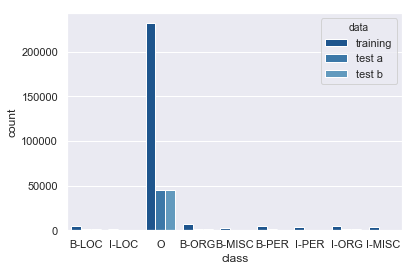

In [48]:
def get_dataframe(training, testa, testb):
    counters = [Counter(),Counter(),Counter()]
    datas = [('training', training), ('test a', testa), ('test b', testb)]
    for counter,(data_name, data) in zip(counters,datas):
        for sent in data:
            for ind in range(len(sent)):
                counter[sent[ind][2]]=counter[sent[ind][2]]+1
    totals = [sum(counter.values()) for counter in counters]
    return DataFrame([{'class':elem, 'count':counter[elem], 'data':data_name,
                       'percent':counter[elem]/total} for elem in counter.keys() for counter,
                       (data_name, data),total in zip(counters,datas,totals)])
d = get_dataframe(etr, eta, etb)
sns.barplot(x='class', y='count', hue='data', data=d)

Since there is much more training data then test data, the test data isn't visible in this chart. Let's plot the relative precentage each class takes from it's data.

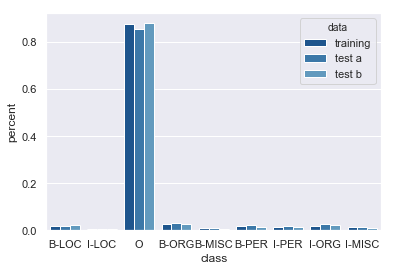

In [49]:
sns.barplot(x='class', y='percent', hue='data', data=d)

We can see that in both the training and the test data, the vast majority of the words (more than 80% in each dataset) are classed as O. That could cause us to overestimate our accuracy, since labeling all words as 'O' will get us a pretty good accuracy.
Let's see the actual numbers of the distribution, and a bar plot of only the training data.

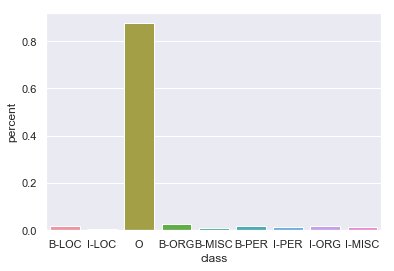

In [50]:
sns.barplot(x='class', y='percent', data=d[d['data']=='training'])

In [250]:
d.sort_values(['count'],ascending=False)

,class,count,data,percent
0,O,183346,training,0.904769
2,O,63117,test b,0.916399
1,O,33973,test a,0.901451
6,B-PER,4716,training,0.023272
15,B-MISC,3338,training,0.016472
3,B-LOC,3208,training,0.015831
9,I-PER,2883,training,0.014227
12,B-ORG,2082,training,0.010274
21,I-MISC,1405,training,0.006933
18,I-ORG,1199,training,0.005917


Let's see the same data for the dutch dataset:

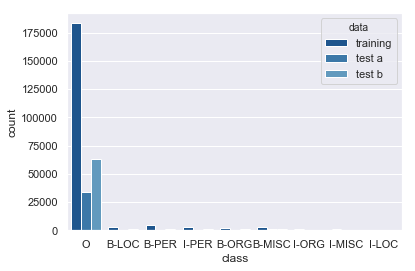

In [52]:
d = get_dataframe(dtr, dta, dtb)
sns.barplot(x='class', y='count', hue='data', data=d)

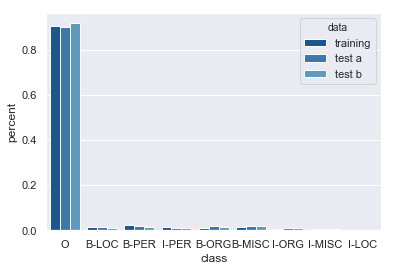

In [53]:
sns.barplot(x='class', y='percent', hue='data', data=d)

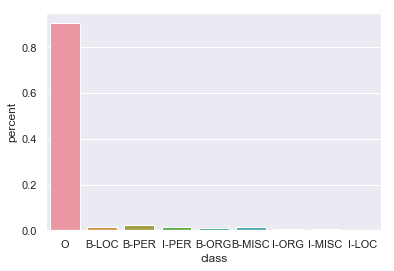

In [54]:
sns.barplot(x='class', y='percent', data=d[d['data']=='training'])

In [249]:
d.sort_values(['count'],ascending=False)

,class,count,data,percent
0,O,183346,training,0.904769
2,O,63117,test b,0.916399
1,O,33973,test a,0.901451
6,B-PER,4716,training,0.023272
15,B-MISC,3338,training,0.016472
3,B-LOC,3208,training,0.015831
9,I-PER,2883,training,0.014227
12,B-ORG,2082,training,0.010274
21,I-MISC,1405,training,0.006933
18,I-ORG,1199,training,0.005917


So, as evident in the bar plot, in all datasets, the 'O' tag is found in more than 80% of the words, while the rest of the tags are less than 3% each.

### 3.1.1 Feature extraction

We want to create a classifier for this task. First, we need to extract features from each word in our dataset.
Let's begin with using only the word form as a feature. We'll use sklearn's DictVectorizer for our feature extraction.

In [56]:
from sklearn.feature_extraction import DictVectorizer

We'll create a method for converting each word into a dictionary, and extracting the label from each word. We want this preprocessing done to the train and test data, so we'll create a method that would preprocess both datasets and return to us the dictionaries and the labels.
We want to use as features the word form of each word, its pos tag (which are given to us), also we'll include the prefixes and suffixes of the word of length 1 and 2, and the orthographic structure of the word, whether it's capitalized, consists only of capital letters, has digits, is a number, etc. We'll first create a method for giving us the orthographic structure of the word.<br>
To check if a word is a number, we'll use the method we've used in assignment 1.

In [90]:
def isNumber(inp):
    try:
        float(inp)
        return True
    except ValueError:
        return False

Now we need to check if the word has a hyphen or digits. Since those features are independent. We'll encode them as two distinct features, independent from the ORT tagging.<br>
The ORT tag will receive five possible values:
* **'number'** - In case it's a number.
* **'allcapital'** - If the entire word is in upper case.
* **'capitalized'** - If the first letter is upper case.
* **'punct'** - If the word is a punctuation.
* **'normal'** - None of the above.

In [92]:
import string

def get_ort(word):
    digits_hyphen = [False, False]
    if isNumber(word):
        return 'number',(True, False)
    for c in word:
        if c in string.digits:
            digits_hyphen[0] = True
        if c == '-':
            digits_hyphen[1] = True
    if word.isupper():
        return 'allcapital',tuple(digits_hyphen)
    if word[0].isupper():
        return 'capitalized',tuple(digits_hyphen)
    if word in string.punctuation:
        return 'punct',tuple(digits_hyphen)
    return 'normal',tuple(digits_hyphen)

Now let's create a method that would extract the feature from a given word. The method would receive a sentence and an index in the sentence (We'll use it later when we'll encode the context as a feature).

In [61]:
def extractFeatures(sent, i):
    word, pos = sent[i][0], sent[i][1]
    ort, (digits, hyphen) = get_ort(word)
    return {'word':word, 'pos': pos, 'prefix1':word[0],
            'ort': ort, 'has_digits':digits, 'has_hyphen':hyphen,
            'suffix1':word[-1],'prefix2':word[:2],'suffix2':word[-2:]}

We'll also create a method that would give us the label of a given word in the data.

In [95]:
def getClass(sent, i):
    return sent[i][2]

Now let's create a method that would, given a dataset, create us a list of all the dictionaries of features of words in the dataset. Also, we'll create a method for generating a list of labels of all the words in the dataset.

In [96]:
def convertToDicts(data):
    return sum([[extractFeatures(sent, i) for i in range(len(sent))] for sent in data],[])

def getClasses(data):
    return sum([[getClass(sent, i) for i in range(len(sent))] for sent in data],[])

And let's create a method that would preprocess the dataset, and would give us the list of features dictionaries, and labels.

In [97]:
def preprocessData(data):
    return convertToDicts(data),getClasses(data)

Now we can generate a list of dictionaries, and a list of labels for each dataset.

In [63]:
x_e_train, y_e_train = preprocessData(etr)
x_d_train, y_d_train = preprocessData(dtr)
x_e_test, y_e_test = preprocessData(eta)
x_d_test, y_d_test = preprocessData(dta)
x_e_testb, y_e_testb = preprocessData(etb)
x_d_testb, y_d_testb = preprocessData(dtb)

Now we'll create our pipeline. Our pipeline will first vectorize our data, using a DictVectorizer. Then the pipeline will pass those vectors to the classifier in order to classify the vectorized data.

In [258]:
from sklearn.linear_model import LogisticRegression

def get_pipeline():
    pipeline = Pipeline([
        ('vectorizer', DictVectorizer(sparse=True)),
        ('classifier', LogisticRegression())
    ])
    return pipeline

In [259]:
pipeline = get_pipeline()

Let's train the model on the spanish training data.

In [65]:
pipeline.fit(x_e_train,y_e_train)

Pipeline(memory=None,
     steps=[('vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

Before testing and evaluating our model, let's create a method that would give us statistics about our model. We want the accuracy, per label recall, percision, and f-score, and the confusion matrix. We'll also plot the confusion matrix as a heat map. Since most of the words are labeled as 'O', we'll have to normalize the confusion matrix before plotting it as a heat map. We'll normalize the heat map by dividing each row by its sum.

In [66]:
from sklearn import metrics
from itertools import product

classes = [loc+'-'+ne_type for loc,ne_type in product(['B','I'],['LOC','PER','ORG','MISC'])]+['O']

def get_report(y_pred, y_true, title):
    print(title)
    print('-'*len(title))
    print('accuracy:{0}\n'.format(sklearn.metrics.accuracy_score(y_pred, y_true)))
    print(sklearn.metrics.classification_report(y_pred, y_true,labels=classes))
    confusion_matrix = metrics.confusion_matrix(y_true,y_pred,labels=classes)
    print('Confusion matrix:\n')
    print(confusion_matrix)
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    confusion_df = DataFrame(confusion_matrix, index=classes, columns=classes)
    fig1 = plt.figure('Confusion Matrix', [10,10])
    ax1 = plt.axes()
    ax1.set_title(title + ' normalized confusion matrix')
    fig1 = sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12})

Let's now test our model on the test dataset, we'll make the predictions on the test dataset.

In [68]:
predictions = pipeline.predict(x_e_test)

Let's see the report and observe how well did our model perform.

Basic features spanish
----------------------
accuracy:0.927895244033785

             precision    recall  f1-score   support

      B-LOC       0.79      0.54      0.64      1441
      B-PER       0.62      0.65      0.63      1154
      B-ORG       0.70      0.75      0.72      1594
     B-MISC       0.41      0.53      0.46       344
      I-LOC       0.36      0.66      0.46       181
      I-PER       0.55      0.48      0.52       978
      I-ORG       0.25      0.51      0.34       681
     I-MISC       0.15      0.49      0.23       203
          O       1.00      0.97      0.99     46347

avg / total       0.95      0.93      0.94     52923

Confusion matrix:

[[  776    30    72     9     4    19    30     2    42]
 [  106   752    44     5    13   231    29     6    36]
 [  201    67  1192    34     2    62    52     5    85]
 [   23    12    51   182     1    15    35    17   109]
 [   27    32     4     3   120    28    39     4    80]
 [   90   146    16     5    11   47

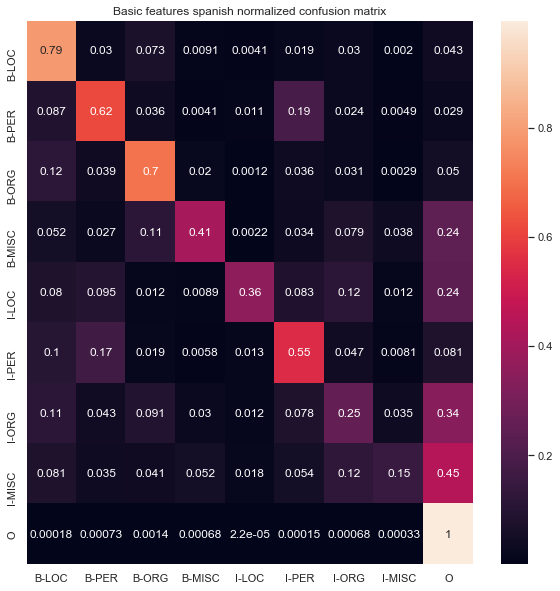

In [69]:
get_report(predictions,y_e_test,'Basic features spanish')

The accuracy is already pretty high, but we know that that can be misleading, since most labels in the training and test data are O. We can observe in the heat map that indeed almost all true O's were labeld as O. Our model performed worse for the I-MISC tag, with an f-score of 0.23, recall of 0.49 and precision of 0.15, in the confusion matrix we can see that most true I-MISC were labeld as O (almost 50%), and few of them (12%) as I-ORG. Only 15% of the I-Misc tags were identified correctly.<br>
Another frequent mistake was labeling B-Per as I-Per, maybe that mistake could be solved by introducing new features to our model, like the previous word, and the next one.<br>

Before doing that, let's see how did our model perform on the dutch dataset.

In [70]:
pipeline.fit(x_d_train,y_d_train)
predictions = pipeline.predict(x_d_test)

Basic features dutch
--------------------
accuracy:0.9507257144373391

             precision    recall  f1-score   support

      B-LOC       0.61      0.64      0.63       452
      B-PER       0.71      0.52      0.60       963
      B-ORG       0.44      0.71      0.54       423
     B-MISC       0.66      0.79      0.72       624
      I-LOC       0.17      0.85      0.29        13
      I-PER       0.44      0.38      0.41       491
      I-ORG       0.32      0.68      0.43       184
     I-MISC       0.16      0.52      0.25        67
          O       1.00      0.98      0.99     34470

avg / total       0.96      0.95      0.95     37687

Confusion matrix:

[[  291    88     8    12     1    50     1     0    28]
 [   26   500    19    12     0   106     5     2    33]
 [   31    70   301    43     0    42    31    13   155]
 [   32    34    33   491     0    35     2     6   115]
 [    4    29     1     0    11     9     0     0    10]
 [   25   153     6     9     0   186  

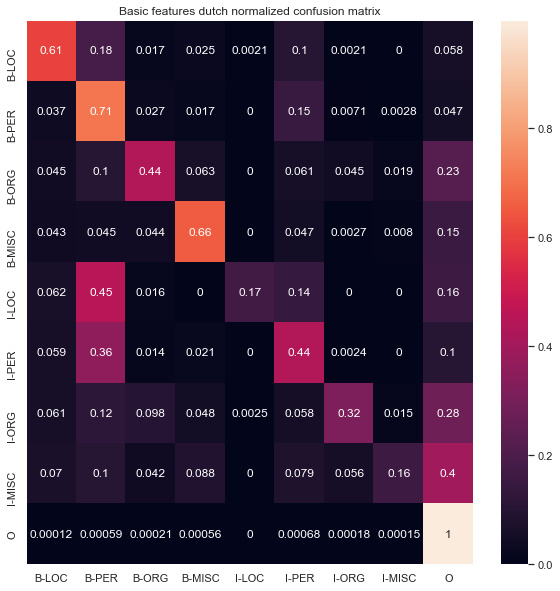

In [71]:
get_report(predictions,y_d_test, 'Basic features dutch')

It's interesting to see that in a different language, the same model does different mistakes. It had much harder time correctly classifying locations. In the label B-LOC it fell from 79% precision to 61%, and in the label I-LOC it fell from 36% precision to 17%. Interestingly, it labeled more true I-LOC words as B-PER. The model did slightly better with B-PER tags, but we can see that it also falsely classify some I-LOC and I-PER tags as B-PER ones. And also the model does slightly better with I-MISC tags than the spanish one, and no longer is such a large part of the words is wrongly classified as I-ORG.

### 3.1.2
Let's now enhance our model, by adding features about the previous and next word. We'll add the previous and next word form, and also it's part of speech tagging. We'll modify the extractFeatures method to include those features.

In [255]:
def extractFeatures(sent, i):
    word, pos = sent[i][0], sent[i][1]
    ort, (digits, hyphen) = get_ort(word)
    return {'word':word, 'pos': pos, 'prefix1':word[0],
            'suffix1':word[-1],'prefix2':word[:2],'suffix2':word[-2:],
            'ort': ort, 'has_digits':digits, 'has_hyphen':hyphen,
            'next_pos':'EOS' if i==len(sent)-1 else sent[i+1][1],
            'prev_pos':'BOS' if i==0 else sent[i-1][1],
            'next':'EOS' if i==len(sent)-1 else sent[i+1][0],
            'prev':'BOS' if i==0 else sent[i-1][0]}

def convertToDicts(data):
    return sum([[extractFeatures(sent, i) for i in range(len(sent))] for sent in data],[])

Now we'll extract the new features from the data.

In [257]:
x_e_train = convertToDicts(etr)
x_e_test = convertToDicts(eta)
x_e_testb = convertToDicts(etb)
x_d_train = convertToDicts(dtr)
x_d_test = convertToDicts(dta)
x_d_testb = convertToDicts(dtb)

Let's train and test the model on the spanish dataset again.

advanced features spanish
-------------------------
accuracy:0.9465827711958884

             precision    recall  f1-score   support

      B-LOC       0.77      0.59      0.67      1298
      B-PER       0.79      0.85      0.82      1132
      B-ORG       0.75      0.78      0.76      1638
     B-MISC       0.43      0.58      0.49       330
      I-LOC       0.55      0.70      0.62       266
      I-PER       0.83      0.75      0.79       942
      I-ORG       0.46      0.72      0.56       871
     I-MISC       0.28      0.59      0.38       313
          O       1.00      0.98      0.99     46133

avg / total       0.96      0.95      0.95     52923

Confusion matrix:

[[  762    24    89     7     7    25    21     3    46]
 [  118   962    21     3     0    46    26     1    45]
 [  184    72  1274    38     4    16    25     8    79]
 [   28    17    60   191     1    12    30     6   100]
 [   20     2     8     4   186    29    30     9    49]
 [   15    18     7     4    

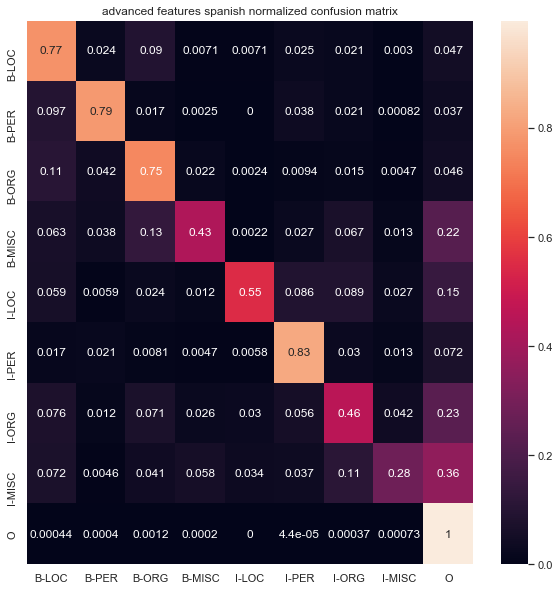

In [74]:
pipeline.fit(x_e_train,y_e_train)
predictions = pipeline.predict(x_e_test)
get_report(predictions,y_e_test, 'advanced features spanish')

We can see that the additional features improved our model. It nearly doubled it's precision with the I-MISC and I-ORG tags. The precision of I-PER also improved, and we now get 83% precision for that label. The precision for B-LOC decreased, but that's the only label whose precision suffered from the addition of new features.<br>
The accuracy improved to nearly 0.95, and the lowest per-label f-score is now 0.38 (was 0.22 with the basic features).<br>
Now let's test the same model with the advenced features on the dutch dataset.

advenced features dutch
-----------------------
accuracy:0.9665667206198424

             precision    recall  f1-score   support

      B-LOC       0.75      0.73      0.74       495
      B-PER       0.79      0.66      0.72       835
      B-ORG       0.56      0.83      0.67       468
     B-MISC       0.74      0.78      0.76       705
      I-LOC       0.20      0.57      0.30        23
      I-PER       0.89      0.63      0.74       597
      I-ORG       0.48      0.84      0.61       226
     I-MISC       0.39      0.64      0.48       130
          O       1.00      0.99      0.99     34208

avg / total       0.97      0.97      0.97     37687

Confusion matrix:

[[  360    63     9    12     2    13     2     0    18]
 [   20   553    12    12     0    53     9     3    41]
 [   48    97   387    68     1    23     8    10    44]
 [   43    53    28   551     1    11     1     3    57]
 [    3    11     0     1    13    24     3     3     6]
 [    4    16     0     7     2  

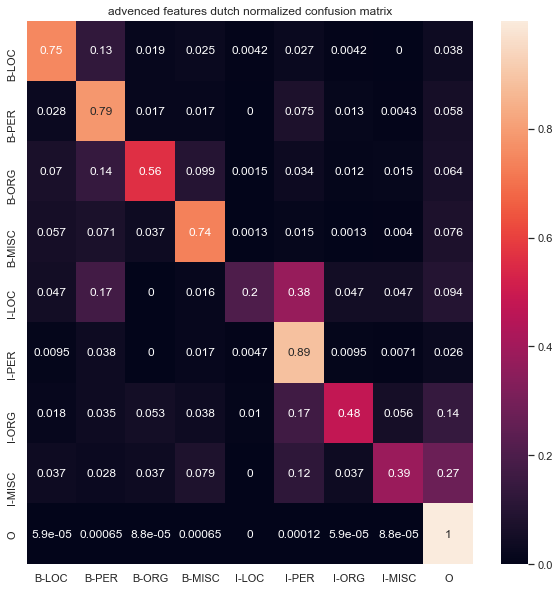

In [107]:
pipeline.fit(x_d_train,y_d_train)
predictions = pipeline.predict(x_d_test)
get_report(predictions,y_d_test, 'advenced features dutch')

The biggest improvement here is the precision of the I-PER tag, which more than doubled itself from 44% to 89%. We can also see that the model falsely tags true I-PER tags as B-PER in less than 4% of the cases, where before he did it in 36% of the cases. The I-LOC label's precision increased slightly, and no longer the model falsely tags this label as B-PER, but now it tags it much more often as I-PER. The I-MISC tag's precision also more than doubled itself, and jumped from 16% to almost 40%. <br>
The accuracy is now almost 0.97.  The big improvement may suggest that the features we added has more significance in dutch than in spanish.<br>
Let's now test our spanish and dutch models on the other test datasets.<br>

advanced features spanish test b
--------------------------------
accuracy:0.9581045155531407

             precision    recall  f1-score   support

      B-LOC       0.71      0.71      0.71      1080
      B-PER       0.86      0.81      0.83       782
      B-ORG       0.82      0.78      0.80      1475
     B-MISC       0.41      0.56      0.47       252
      I-LOC       0.40      0.71      0.51       182
      I-PER       0.91      0.78      0.84       741
      I-ORG       0.52      0.73      0.61       790
     I-MISC       0.25      0.61      0.35       228
          O       1.00      0.98      0.99     46003

avg / total       0.97      0.96      0.96     51533

Confusion matrix:

[[  770    40   125     5    14    21    33     7    69]
 [   31   633    17     2     1    24     5     4    18]
 [  101    60  1144    17     3    21    24     7    23]
 [   25     8    62   140     1     8    19    13    63]
 [   33     4    16     3   129    22    44     4    70]
 [    7     7  

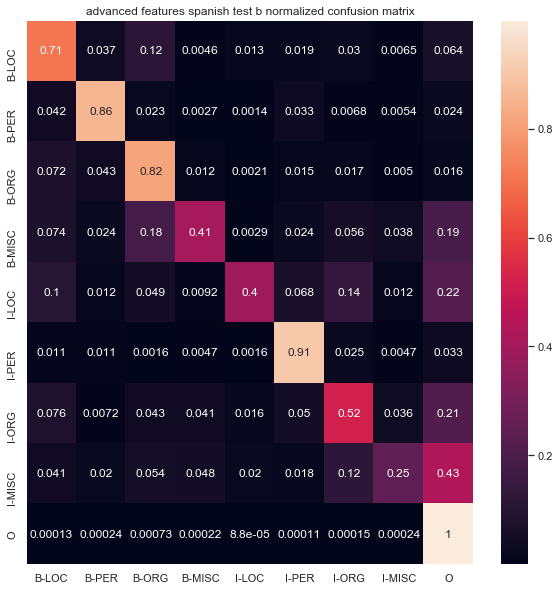

In [262]:
pipeline.fit(x_e_train,y_e_train)
predictions = pipeline.predict(x_e_testb)
get_report(predictions,y_e_testb, 'advanced features spanish test b')

While not exactly the same, it's interesting to see that on the other test dataset our model makes the same kinds of mistakes as he did on the first dataset. Perhaps that indicates that the features we choose doesn't capture some meanings in the spanish language well enough.<br>
Let's now see how our model performs on the other dutch dataset:

advanced features dutch test b
------------------------------
accuracy:0.9731833030852994

             precision    recall  f1-score   support

      B-LOC       0.75      0.78      0.77       744
      B-PER       0.84      0.72      0.77      1275
      B-ORG       0.60      0.76      0.67       698
     B-MISC       0.71      0.76      0.73      1102
      I-LOC       0.41      0.65      0.50        31
      I-PER       0.89      0.71      0.79      1012
      I-ORG       0.48      0.84      0.61       317
     I-MISC       0.30      0.69      0.41       176
          O       1.00      0.99      1.00     63520

avg / total       0.98      0.97      0.97     68875

Confusion matrix:

[[  581    81    23    24     1    23     1     2    38]
 [   24   918    19    21     2    45     4     7    58]
 [   41   109   527   117     1    27     4     5    51]
 [   37    84    96   841     0    22     4     4    99]
 [    2     1     0     1    20    13     3     6     3]
 [    9    18     7

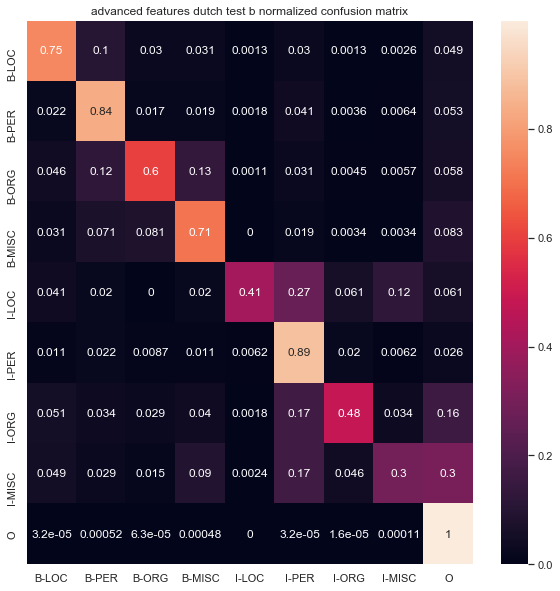

In [263]:
pipeline.fit(x_d_train,y_d_train)
predictions = pipeline.predict(x_d_testb)
get_report(predictions,y_d_testb, 'advanced features dutch test b')

We can see that on the other test data our dutch model did less I-LOC -> I-PER mistakes, but all in all the rates remained relatively similar, like in the spanish dataset.

### 3.1.3
We used greedy tagging, that means that we labeled each word as if it is independent from the other tags, although we know that some sequences are illegal, for example if IX is followed by IY, or IX follows an O.<br>
We want to create a method to check if our model generates such illegal sequences.<br>
First, let's create a method that would check if two given consecutive tags are illegal.

In [99]:
i_labels = [label for label in classes if label[0]=='I']
b_labels = [label for label in classes if label[0]=='B']
o_label = ['O']

def legal_seq(last, curr):
    if last in o_label and curr in i_labels:
        return False
    if last in i_labels and curr in i_labels and i_labels.index(last)!=i_labels.index(curr):
        return False
    if last in b_labels and curr in i_labels and b_labels.index(last)!=i_labels.index(curr):
        return False    
    return True 

Now, let's create a method that would go over the entire dataset, and will return as a list of the illegal sequences in it.

In [213]:
def find_illegal(data, pipeline):
    l = []
    for sent in data:
        last_d = extractFeatures(sent, 0)
        last = pipeline.predict(last_d)[0]
        for ind in range(1,len(sent)):
            d = extractFeatures(sent, ind)
            curr = pipeline.predict(d)[0]
            if not legal_seq(last, curr):
                l.append({'last_tag':last,'curr_tag':curr,'last_type':last[0],'curr_type':curr[0],
                          'last_ner':'O' if last=='O' else last[2:], 'curr_ner':'O' if curr=='O' else curr[2:],
                          'last_word':last_d['word'],'curr_word':d['word']})
            last = curr
            last_d = d
    return l

Let's run this method on the dutch training dataset and see if we are getting such illegal sequences.

In [214]:
illegal_list = find_illegal(dtr, pipeline)

In [237]:
len(illegal_list)

651

We can see that we have 651 such illegal transitions. It could be interesting to see how those illegal transition distribute. How many of them are of the type O->I? How many IX->IY? And how many BX->IY?
<br><br>
Let's plot a barplot of that distriubtion.

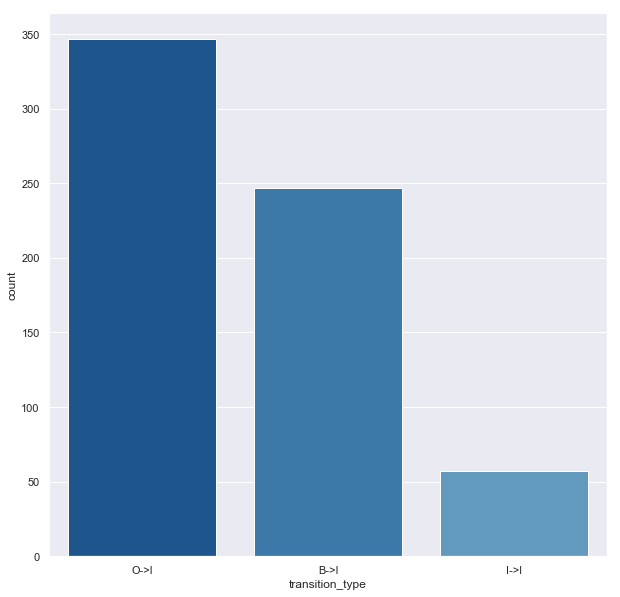

In [236]:
df = DataFrame(illegal_list)
fig1 = plt.figure('Transition types', [10,10])
df['transition_type'] = df['last_type'] + '->' + df['curr_type']
fig1 = sns.countplot(x='transition_type', data=df)

As expected, most transitions are O->I, but that can be simply because there are much more O tags then any of the other tags. Let's plot how the transitions changed between two different NER, when the transition is of type B->I.

[]

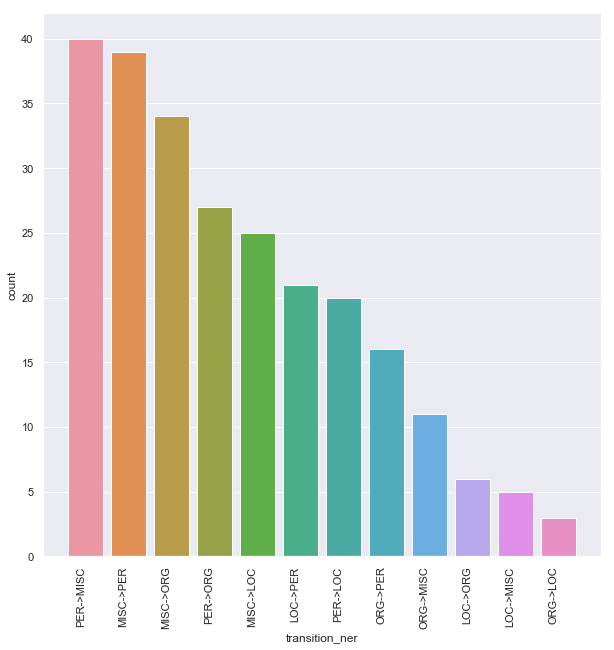

In [240]:
df['transition_ner'] = df['last_ner'] + '->' + df['curr_ner']
bi_df = df[df['transition_type']=='B->I']
fig1 = plt.figure('Transition types', [10,10])
fig1 = sns.countplot(x='transition_ner', order = bi_df['transition_ner'].value_counts().index, data=bi_df)
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90, ha="right")
fig1.plot()

PER and MISC are the most common tags in the dataset, so it's not suprising that those are the most common mistakes are classifier does. I-ORG is relatively uncommon, but we can see in the confusion matrix that the classifier mistakenly labeled I-MISC as I-ORG in 17% of the times. So that explains why that transition is realtively common.

[]

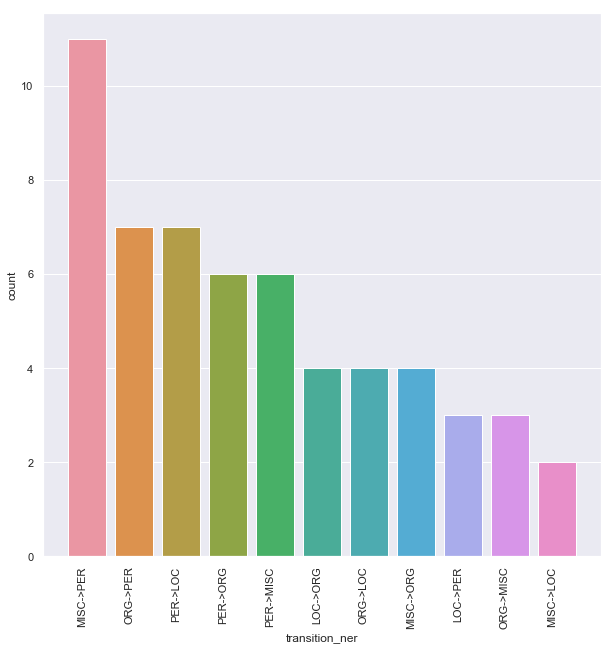

In [242]:
ii_df = df[df['transition_type']=='I->I']
fig1 = plt.figure('Transition types', [10,10])
fig1 = sns.countplot(x='transition_ner', order = ii_df['transition_ner'].value_counts().index, data=ii_df)
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90, ha="right")
fig1.plot()

Here too, since PER and MISC are the most common, it's not suprising to find this illegal transition as the most common.<br>
Let's see how the NER distribute among the transitions O->I.

[]

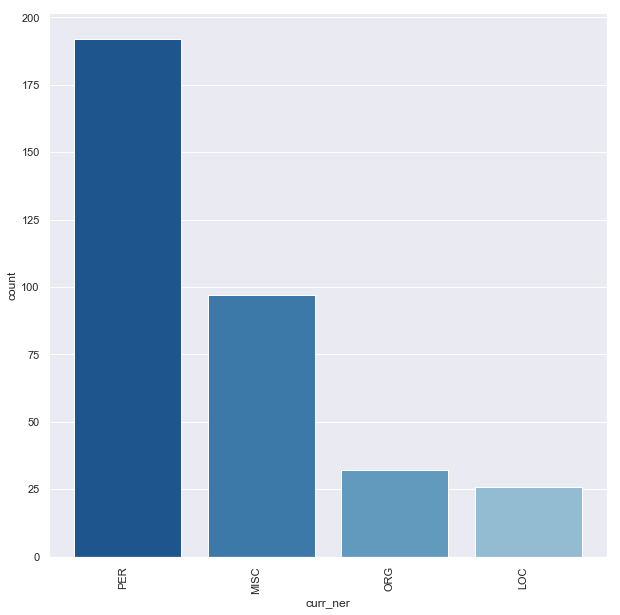

In [251]:
oi_df = df[df['transition_type']=='O->I']
fig1 = plt.figure('Transition types', [10,10])
fig1 = sns.countplot(x='curr_ner', order = oi_df['curr_ner'].value_counts().index, data=oi_df)
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90, ha="right")
fig1.plot()

The rates of mistakes here correspond to the rates of the occourrences of each tag in the data.<br>
Let's see now a plot bar of how the all illegal transition distribute.

[]

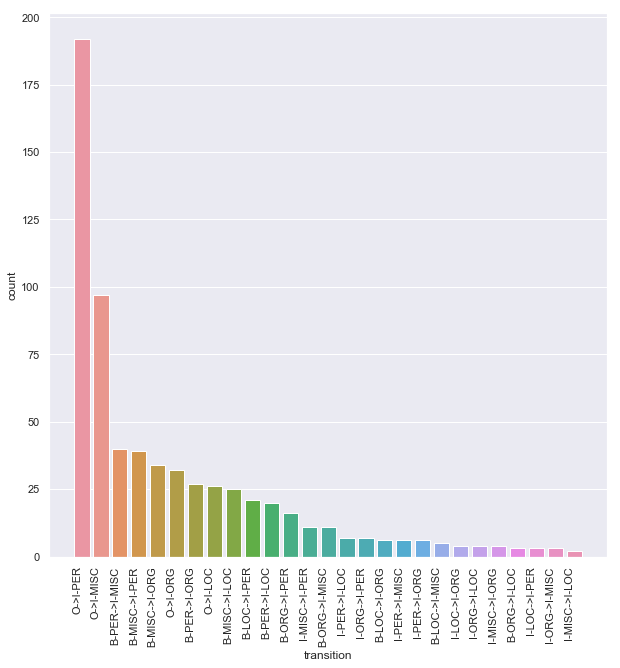

In [235]:
df['transition'] = df['last_tag'] + '->' + df['curr_tag']
fig1 = plt.figure('Transition types', [10,10])
fig1 = sns.countplot(x='transition', order = df['transition'].value_counts().index, data=df)
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=90, ha="right")
fig1.plot()

So, all in all the rates of the mistakes in the illegal sequences are explained by the frequency of the tags in the data, and the frequencies of the mistakes the classifier makes. <br>
It's not suprising at all that our classifier did such mistakes, since we didn't encode in any way the legality of sequences into it, and as mentioned, he tags greedily. Since the confusion matrix contains IX->IY mistakes, there are certainly illegal sequence.

### 3.2 Word embeddings
We'll try to further enhance our model by adding word embeddings to it as a feature. Word embeddings can capture the true semantic meaning of the word, so using them can benefit us more than using the one-hot encoding for words we've used until now.<br>
We'll use pre-trained 300-dimensional dutch word vectors trained on Wikipedia using a skipgram model as described in the paper :<br>
P. Bojanowski\*, E. Grave\*, A. Joulin, T. Mikolov, [*Enriching Word Vectors with Subword Information*](https://arxiv.org/abs/1607.04606)<br>
In order to manipulate those vectors, we'll use the gensim library. Let's import it:

In [80]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim.models import KeyedVectors

And let's import the word embedding:

In [81]:
wv_from_text = KeyedVectors.load_word2vec_format('data/wiki.nl.vec', binary=False)  # C text format

Let's see how many words in the dataset aren't found in the embedding:

In [252]:
total = len(x_d_test)
len([w for w in x_d_test if w['word'].lower() not in wv_from_text])/total

0.045586011091357764

About 4% of the words in the dataset aren't found in the embedding.<br>
There are several ways to handle such cases. We can either find a word we have embedding to with a small edit distance to our word, or try and find a subword of our word which is found in the dictionary. I choose to handle such cases in a not-optimal but simple way - I'll simply encode all those unknown words as the the zero-vector. It's problematic since all the unknown words will be identical in that case, moreover, some words in the embedding are closer to the zero vectors than other, which will add unwanted and untrue meaning to the embedding. But it's the simplest method, and since we only have 4% of unknown words in the dataset, I hope it won't harm our model too much.

We want to add the embedding as a feature to our model. We'll create a new EmbedTranformer, which will be given the embeddings in its construction. The transformer will be able to transform either the current, the previous or the next word in the sentence to it's appropriate embedding.

In [253]:
class EmbedTransformer(TransformerMixin):

    def __init__(self, w2vec,kword='word'):
        self.w2vec = w2vec
        self.vec_len = len(w2vec['de'])
        self.zero_vec = np.zeros(self.vec_len, dtype='float32')
        self.kword = kword
    
    def transform(self, X, **transform_params):
        return np.array([self.zero_vec if x[self.kword] not in self.w2vec else self.w2vec[x[self.kword].lower()] for x in X], dtype='float32')

    def fit(self, X, y=None, **fit_params):
        return self

Now let's create our pipeline. Our features would consist of the DictVectorizer, and the embedding of the current, previous, and next word.

In [254]:
def get_pipeline2():
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('vectorizer', DictVectorizer(sparse=True)),
            ('embedding_word', EmbedTransformer(wv_from_text)),
            ('embedding_next', EmbedTransformer(wv_from_text,kword='next')),
            ('embedding_prev', EmbedTransformer(wv_from_text,kword='prev'))
        ])),
        ('classifier', LogisticRegression())
    ])
    return pipeline

In [83]:
pipeline = get_pipeline2()

Let's fit our method to the training dutch data.

In [84]:
pipeline.fit(x_d_train,y_d_train)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('vectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)), ('embedding_word', <__main__.EmbedTransformer object at 0x000001EB32F0F4E0>), ('embedding_next', <__main__.EmbedTransforme...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

And see how it performs on the dutch test data.

Dutch features with word embedding
----------------------------------
accuracy:0.9679465067529918

             precision    recall  f1-score   support

      B-LOC       0.77      0.72      0.74       511
      B-PER       0.80      0.70      0.75       810
      B-ORG       0.59      0.84      0.69       483
     B-MISC       0.72      0.79      0.75       690
      I-LOC       0.22      0.47      0.30        30
      I-PER       0.91      0.67      0.77       574
      I-ORG       0.51      0.82      0.63       245
     I-MISC       0.46      0.61      0.52       160
          O       1.00      0.99      0.99     34184

avg / total       0.97      0.97      0.97     37687

Confusion matrix:

[[  367    50    16    16     3     3     3     0    21]
 [   23   564    15    17     0    33     7     6    38]
 [   50   101   404    67     0    11     6     4    43]
 [   46    50    29   542     1     6     3     7    64]
 [    3     3     0     1    14    27     6     5     5]
 [    4    

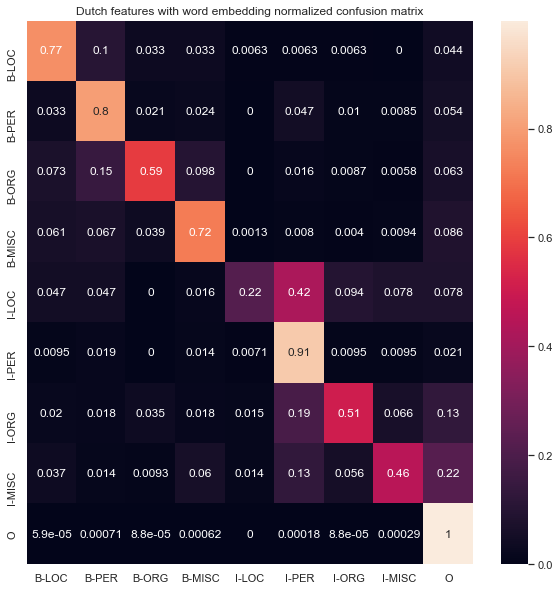

In [86]:
predictions = pipeline.predict(x_d_test)
get_report(predictions,y_d_test, 'Dutch features with word embedding')

The accuracy got slightly better, and we reached almost 0.97. and we can see that the precision got better for all labels, apart from B-MISC which went down from 0.74 to 0.72.<br>
Let's test this embedding on the other test dataset.

Dutch features with word embedding, test b
------------------------------------------
accuracy:0.9749110707803993

             precision    recall  f1-score   support

      B-LOC       0.77      0.79      0.78       751
      B-PER       0.84      0.73      0.78      1263
      B-ORG       0.62      0.77      0.69       708
     B-MISC       0.72      0.80      0.76      1065
      I-LOC       0.37      0.60      0.46        30
      I-PER       0.92      0.75      0.82       997
      I-ORG       0.54      0.80      0.65       373
     I-MISC       0.36      0.63      0.46       237
          O       1.00      0.99      1.00     63451

avg / total       0.98      0.97      0.98     68875

Confusion matrix:

[[  594    79    28    22     3     8     0     2    38]
 [   24   924    23    20     2    38     8    13    46]
 [   45   114   548   109     0    10     4     7    45]
 [   44    87    88   854     1     8     7     2    96]
 [    2     0     0     1    18    15     4     6   

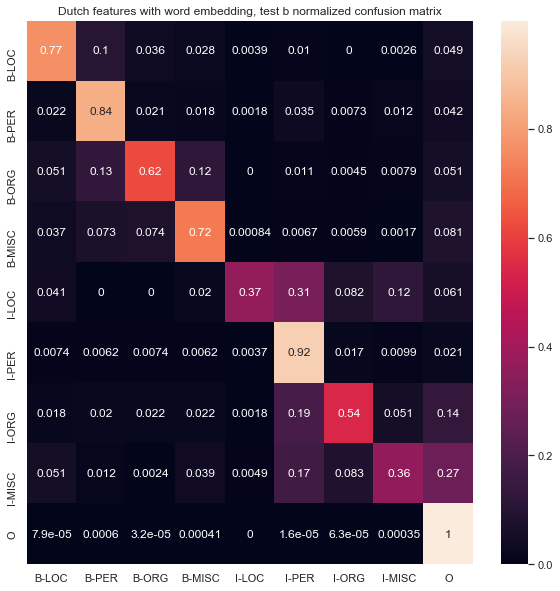

In [89]:
predictions = pipeline.predict(x_d_testb)
get_report(predictions,y_d_testb,'Dutch features with word embedding, test b')

Word embeddings capture the semantic meaning of the word, so it would be interesting to see how our model would perform when the only data it will be given are the words embeddings. I expect that since there are 4% of unknown words in our dataset, and since our task needs more than just the semantic meaning of the word for a successful tagging, for example it's orthographic structure, our model will perform less far better than our previous one. But it will still be interesting to see where it will do better.<br><br>
Before doing that, for sanity check, let's see how a model which simply randomly assigns labels with the probability of their occurrences in the dataset will perform, that way we will be able to tell whether the word embeddings themselves have values as features.

Random permutation
------------------
accuracy:0.8136758033274073

             precision    recall  f1-score   support

      B-LOC       0.01      0.01      0.01       479
      B-PER       0.02      0.02      0.02       703
      B-ORG       0.01      0.01      0.01       686
     B-MISC       0.01      0.01      0.01       748
      I-LOC       0.00      0.00      0.00        64
      I-PER       0.01      0.01      0.01       423
      I-ORG       0.00      0.00      0.00       396
     I-MISC       0.00      0.00      0.00       215
          O       0.90      0.90      0.90     33973

avg / total       0.81      0.81      0.81     37687

Confusion matrix:

[[    6     4     7     9     2     6     7     4   434]
 [   15    11    14    12     3     8     4     7   629]
 [   10    12     8    14     1     5     4     5   627]
 [   10    18    17     6     1    10     9     4   673]
 [    1     2     2     2     0     1     0     0    56]
 [    4     9     7    15     0     4     6

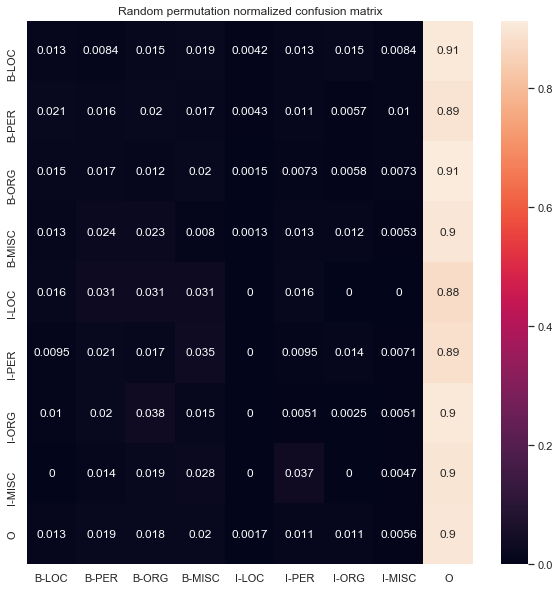

In [283]:
get_report(np.random.permutation(y_d_test),y_d_test, 'Random permutation')

Now let's hope that our model will do better than that, and maybe will be able to understand the strengths and weaknesses of word embeddings further.

In [268]:
def get_pipeline3():
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('embedding_word', EmbedTransformer(wv_from_text)),
            ('embedding_next', EmbedTransformer(wv_from_text,kword='next')),
            ('embedding_prev', EmbedTransformer(wv_from_text,kword='prev'))
        ])),
        ('classifier', LogisticRegression())
    ])
    return pipeline

In [269]:
pipeline = get_pipeline3()

In [270]:
pipeline.fit(x_d_train,y_d_train)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('embedding_word', <__main__.EmbedTransformer object at 0x000001EC0D8C6240>), ('embedding_next', <__main__.EmbedTransformer object at 0x000001EC0D8C6518>), ('embedding_prev', <__main__.EmbedTransformer object at 0x000001EC0D8C6208>)...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

Dutch features only word embedding
----------------------------------
accuracy:0.9156207710881736

             precision    recall  f1-score   support

      B-LOC       0.43      0.47      0.45       443
      B-PER       0.37      0.48      0.42       546
      B-ORG       0.06      0.47      0.10        85
     B-MISC       0.35      0.51      0.41       505
      I-LOC       0.00      0.00      0.00         1
      I-PER       0.10      0.38      0.16       114
      I-ORG       0.00      0.00      0.00        12
     I-MISC       0.04      0.38      0.08        24
          O       0.99      0.94      0.96     35957

avg / total       0.96      0.92      0.94     37687

Confusion matrix:

[[  207    40    14    22     0     0     0     0   196]
 [   45   262     8    10     0     4     0     0   374]
 [   79   120    40    96     0     6     1     0   344]
 [   28    47     8   259     0    15     0     2   389]
 [    2     1     1     0     0     1     0     0    59]
 [    1    

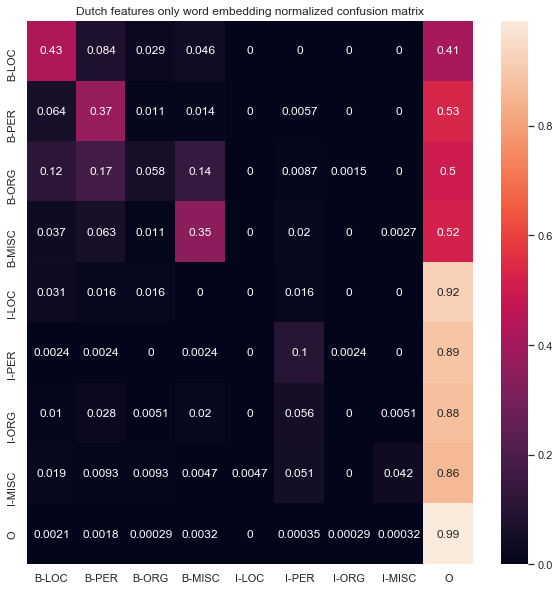

In [271]:
predictions = pipeline.predict(x_d_test)
get_report(predictions,y_d_test, 'Dutch features only word embedding')

As expected, our model didn't perform well. We got accuracy of 0.91 but that simply since most of our tags are 'O'. The model did best with locations and persons, and we can see that it had relatively hard time with organizations, perhaps they don't exist in the word embedding given to us?<br>
Also, we can see that for the I-LOC, I-ORG and I-MISC tags, are word-embeddings classifier did not much better than our random classifier. We already saw that for organizations are classifier didn't do well, but not classifying I-LOC well, after classifying B-LOC well is suprising, we can see that it classified 3% of the I-LOC tags as B-LOC, most likely the semantic meaning isn't enough for the task of differntating between I-LOC and B-LOC.<br> For the I-tags, are classifier did best with the I-PER tags, maybe since most of those are family names, and you can understand that from the semantic meaning.<br>
To summarize, for the task of NER word embedding are a great addition to existing features, and perhaps better word embeddings could achieve better results, but since NER demands more than the semantic meaning of the word, it seems that the other features are needed as well.